# CNN on Custom Images
For this exercise we're using a collection of Cats and Dogs images inspired by the classic <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle competition</a>.

In the last section we downloaded the files, looked at the directory structure, examined the images, and performed a variety of transforms in preparation for training.

In this section we'll define our model, then feed images through a training and validation sequence using DataLoader.



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Define transforms
In the previous section we looked at a variety of transforms available for data augmentation (rotate, flip, etc.) and normalization.<br>
Here we'll combine the ones we want, including the <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>recommended normalization parameters</a> for mean and std per channel.

In [10]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
# test set doesn't need RandomRotation and RandomHorizontalFlip
test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [14]:
root = '/Users/arissa/Desktop/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


## Display a batch of images
To verify that the training loader selects cat and dog images at random, let's show a batch of loaded images.<br>
Recall that imshow clips pixel values <0, so the resulting display lacks contrast. We'll apply a quick inverse transform to the input tensor so that images show their "true" colors.

In [20]:
for images,labels in train_loader: 
    break
images.shape

torch.Size([10, 3, 224, 224])

Label: [1 1 1 1 1 1 1 1 1 0]
Class: DOG DOG DOG DOG DOG DOG DOG DOG DOG CAT


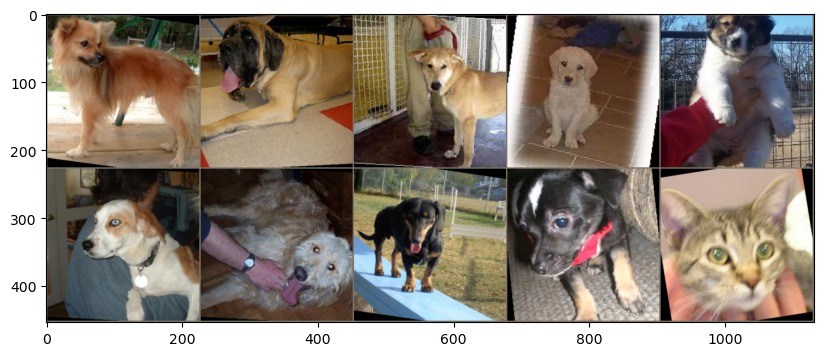

In [22]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the model
We'll start by using a model similar to the one we applied to the CIFAR-10 dataset, except that here we have a binary classification (2 output channels, not 10). Also, we'll add another set of convolution/pooling layers.

In [27]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 color channels, 6 filters
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        # 16 filters
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # ((224-2)/2-2)/2 we have cnn layer and pooling layer
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [31]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### Looking at the trainable parameters

In [33]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [35]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


## Train the model
In the interests of time, we'll limit the number of training batches to 800, and the number of testing batches to 300. We'll train the model on 8000 of 18743 available images, and test it on 3000 out of 6251 images.

In [ ]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800 # each batch has 10 images
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.58529770  accuracy:  55.300%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.56967199  accuracy:  57.275%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.72321194  accuracy:  60.117%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.46714419  accuracy:  61.612%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.46323052  accuracy:  67.850%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.74060732  accuracy:  69.625%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.53277290  accuracy:  69.783%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.51653355  accuracy:  70.263%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.33977121  accuracy:  74.700%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.49512810  accuracy:  74.500%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.64841616  accuracy:  74.667%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.48453364  accuracy:  74.600%


In [ ]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')